# Load data using dataframe.

In [198]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import os

In [199]:
# Load data in file Data/Session_3.csv into a pandas dataframe  

# Load data from file
data = pd.read_csv(os.path.join('Data','Session_1.csv'))

# Display the data
print(data)




           Time   Resp    ECG    EDA Trigger
0         0.000  475.0  461.0  236.0    -1.0
1         0.001  475.0  456.0  236.0    -1.0
2         0.002  475.0  455.0  236.0    -1.0
3         0.003  475.0  454.0  235.0    -1.0
4         0.004  474.0  453.0  236.0    -1.0
...         ...    ...    ...    ...     ...
598995  598.995  575.0  513.0  194.0    -1.0
598996  598.996  575.0  513.0  195.0    -1.0
598997  598.997  575.0  509.0  194.0    -1.0
598998  598.998  574.0  503.0  195.0    -1.0
598999  598.999  575.0  497.0  195.0    -1.0

[599000 rows x 5 columns]


In [200]:
# change value in position i in Trigger column to -1.0 if the value in  sample i-1 was 'p', '0', or '1'



# Create a list of the indexes of the rows that need to be changed
indexes_to_change = []
for i in range(1, len(data)):
    if data.loc[i-1, 'Trigger'] in ['p', '0', '1']:
        indexes_to_change.append(i)

# Change the values in the Trigger column
data.loc[indexes_to_change, 'Trigger'] = '-1.0'

# change p in Trigger column to 9.0
data.loc[data['Trigger'] == 'p', 'Trigger'] = '-1.0'


# Convert the values in the Trigger column to float
data['Trigger'] = data['Trigger'].astype(float)

# get trigger values above -1
trigger_values = data[data['Trigger'] > -1.0]['Trigger']

print(trigger_values.values)



[1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]


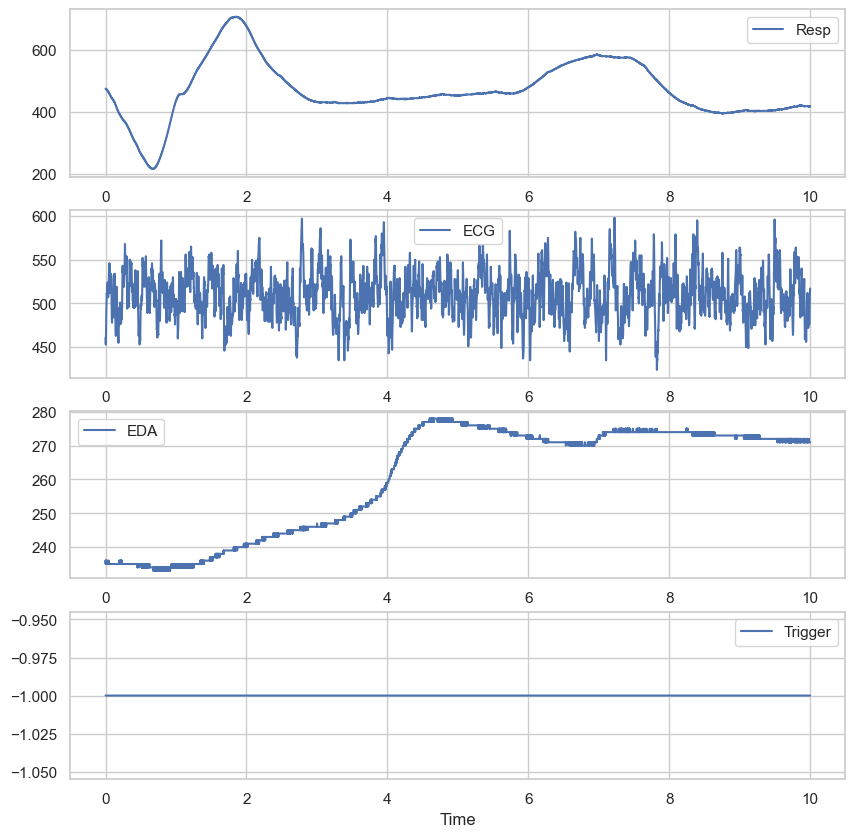

In [201]:
# plot the data, x-axis is the first column, subplots for the second, third and fourth column

# figure with 3 subplots only show 10 seconds of data
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# plot the data
data.iloc[:10000].plot(x='Time', y='Resp', ax=axs[0])
data.iloc[:10000].plot(x='Time', y='ECG', ax=axs[1])
data.iloc[:10000].plot(x='Time', y='EDA', ax=axs[2])

data.iloc[:10000].plot(x='Time', y='Trigger', ax=axs[3])

# show the plot
plt.show()



In [202]:
# segment data using column trigger
# find the indices where the trigger is 1
triggers = data['Trigger'] == 1
indices = np.where(triggers)[0]

print(indices)
segmentSize=100

# segment the data
segments = []
for i in range(len(indices) - 1):
    segments.append(data.iloc[indices[i]:indices[i]+segmentSize])


[ 28000  85000 113000 198000 281000 309000 338000 453000 481000 539000]


In [203]:
# compute average of segments
averages = []
for segment in segments:
    averages.append(segment.mean())

    

In [204]:
averages

[Time        28.0495
 Resp       475.9700
 ECG        501.5100
 EDA        261.8800
 Trigger     -0.9800
 dtype: float64,
 Time        85.0495
 Resp       405.0600
 ECG        504.1900
 EDA        251.9600
 Trigger     -0.9800
 dtype: float64,
 Time       113.0495
 Resp       370.4900
 ECG        507.8100
 EDA        270.1600
 Trigger     -0.9800
 dtype: float64,
 Time       198.0495
 Resp       433.6400
 ECG        496.0700
 EDA        245.3400
 Trigger     -0.9800
 dtype: float64,
 Time       281.0495
 Resp       477.5100
 ECG        500.9700
 EDA        194.1500
 Trigger     -0.9800
 dtype: float64,
 Time       309.0495
 Resp       398.6000
 ECG        511.5600
 EDA        191.2000
 Trigger     -0.9800
 dtype: float64,
 Time       338.0495
 Resp       456.1200
 ECG        489.0700
 EDA        187.0000
 Trigger     -0.9800
 dtype: float64,
 Time       453.0495
 Resp       437.0500
 ECG        533.3500
 EDA        181.2800
 Trigger     -0.9800
 dtype: float64,
 Time       481.0495
 Re

In [205]:
import neurokit2 as nk

# compute the EDA features
eda_features = nk.eda_process(data['EDA'], sampling_rate=1000)

# display the features
eda_features


(        EDA_Raw   EDA_Clean   EDA_Tonic  EDA_Phasic  SCR_Onsets  SCR_Peaks  \
 0         236.0  236.002408  242.660133   -6.657725           0          0   
 1         236.0  235.990369  242.662886   -6.672517           0          0   
 2         236.0  235.978338  242.665639   -6.687301           0          0   
 3         235.0  235.966317  242.668393   -6.702076           0          0   
 4         236.0  235.954308  242.671147   -6.716840           0          0   
 ...         ...         ...         ...         ...         ...        ...   
 598995    194.0  194.546479  188.600798    0.019671           0          0   
 598996    195.0  194.546479  188.600798    0.018158           0          0   
 598997    194.0  194.546479  188.600798    0.016646           0          0   
 598998    195.0  194.546479  188.600798    0.015133           0          0   
 598999    195.0  194.546479  188.600798    0.013620           0          0   
 
         SCR_Height  SCR_Amplitude  SCR_RiseTime  

In [206]:
ecg_cleaned = nk.ecg_clean(data['ECG'], sampling_rate=1000)

instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
_, waves_peak = nk.ecg_delineate(data['ECG'], rpeaks, sampling_rate=1000, method="peak")

rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


# Prepare output
signals = pd.DataFrame({"ECG_Raw": data['ECG'],
                        "ECG_Clean": ecg_cleaned,
                        "ECG_Rate": rate,
                        "ECG_Quality": quality})


signals = pd.concat([signals, instant_peaks], axis=1)

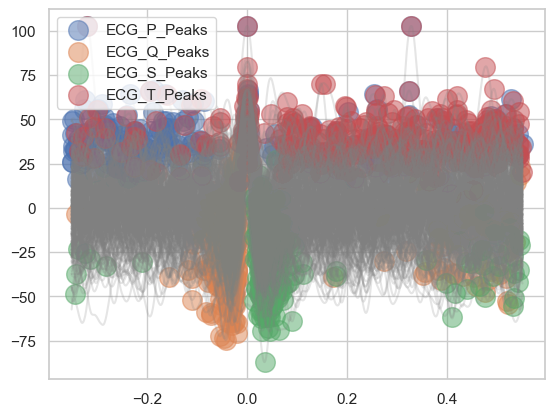

In [207]:
signal_dwt, waves_dwt = nk.ecg_delineate(signals, 
                                        rpeaks, 
                                        sampling_rate=1000, 
                                        method="dwt", 
                                        show=True, 
                                        show_type='peaks')

In [208]:
epochs=[]

# Process the data for event-related analysis
df, info = nk.bio_process(ecg=signals['ECG_Clean'], sampling_rate=1000)


events = nk.events_find(data["Trigger"], threshold=-1.0, event_conditions=trigger_values.values, threshold_keep='above')

epochs = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=-2.0, epochs_end=6.0)

# Analyze
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=1000)

# Get a dataframe with all the results

analyze_epochs

/opt/anaconda3/envs/summerschool/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/opt/anaconda3/envs/summerschool/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/opt/anaconda3/envs/summerschool/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/opt/anaconda3/envs/summerschool/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` co

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Quality_Mean
1,1,1.0,28000,44.929399,1.982251,-28.492436,-9.956322,10.890949,1.609451,6.000000,-1.970021,4.230720,0.972231,0.695311
2,2,0.0,56000,5.468640,77.175988,-0.002665,33.364844,23.868930,2.766596,0.150269,41.213378,-22.590023,0.687336,0.731750
3,3,1.0,85000,8.180709,92.829392,-0.026319,34.186880,24.826772,1.064383,0.470309,4.502389,25.280901,0.025286,0.738870
4,4,1.0,113000,81.741031,29.990812,-47.591914,-10.140718,21.662657,2.227528,3.984748,-7.815859,-0.368029,0.026020,0.828424
5,5,0.0,141000,61.749679,43.884124,-51.512524,-19.011389,31.452110,0.856357,6.000000,-26.258857,40.017521,0.833099,0.882665
6,6,0.0,169000,57.607037,107.682220,-47.447876,-31.114184,29.728704,5.794974,5.431929,-41.411369,9.288591,0.398429,0.924599
7,7,1.0,198000,80.592702,4.033533,-71.654871,-49.551799,23.944843,0.092262,6.000000,-33.583323,9.338334,0.989362,0.734459
8,8,0.0,225000,15.334387,12.464535,0.000131,2.631235,3.156174,6.000000,0.001250,-1.560730,0.976703,0.979955,0.772660
9,9,0.0,254000,17.713551,55.815861,-4.077187,14.535751,18.966799,2.924616,2.108514,26.979299,-21.795413,0.458365,0.961330
10,10,1.0,281000,32.263466,33.743135,-20.534996,0.194168,17.974048,1.195399,6.000000,-4.216780,22.053379,0.735349,0.803130


In [209]:
analyze_epochs.columns

Index(['Label', 'Condition', 'Event_Onset', 'ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean'],
      dtype='object')

<Axes: xlabel='Condition', ylabel='ECG_Rate_Max'>

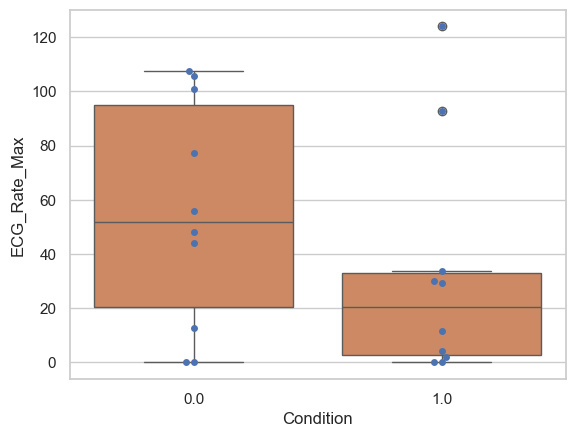

In [210]:
# show feature ECG_Rate_Baseline grouped by condition 0 and 1 using seaborn with points
#sns.swarmplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)
#sns.boxplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)



sns.swarmplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)
sns.boxplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)


